# Определение возраста покупателей

## Исследовательский анализ данных

Импортируем библиотеки

In [11]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


Делаем загрузку данных

In [12]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Создаём функцию вывода основной информации о выборке на экран

In [13]:
def show_i(data):

    '''Выводим на экран следущую информацию:

    - размер выборки
    - основную информацию
    - первые 5 строк таблицы
    - суммарная статистика по числовым параметрам
    - суммарная статистика по нечисловым параметрам'''

    display(data.shape)
    display(data.info())
    display(data.head())
    display(data.describe())
    display(data.describe(include=['O']))

Применяем функцию

In [14]:
show_i(labels)

(7591, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


,file_name
count,7591
unique,7591
top,007039.jpg
freq,1


`Вывод:` выборка содержит 7591 строки и два признака: название файла и возраст изображённого на фото человека.

медианный возраст - 29 лет, средний - 31,2 года

Минимальный и максимальный возраст: 1 и 100 лет сответственно.

График распределения возраста в выборке.

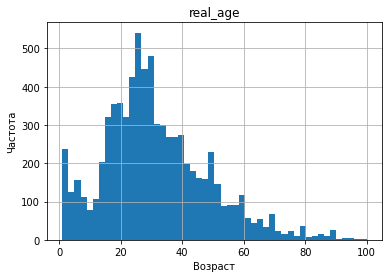

In [15]:
labels.hist(bins=50)

# Названия осей
plt.xlabel('Возраст')
plt.ylabel('Частота')

# Выводим график
plt.show()

`Вывод:`  Распределение больше напоминает Пуассоновское нежли нормальное с локальным всплеском околонулевых значений. Пики на графике, возможно, вызваны особенностями сбора информации, или техническим сбоем во время генерации выборки при первичном сборе данных. Предположу, что эти выбросы можно классифицировать как шум в данных.

Выводим фотографии

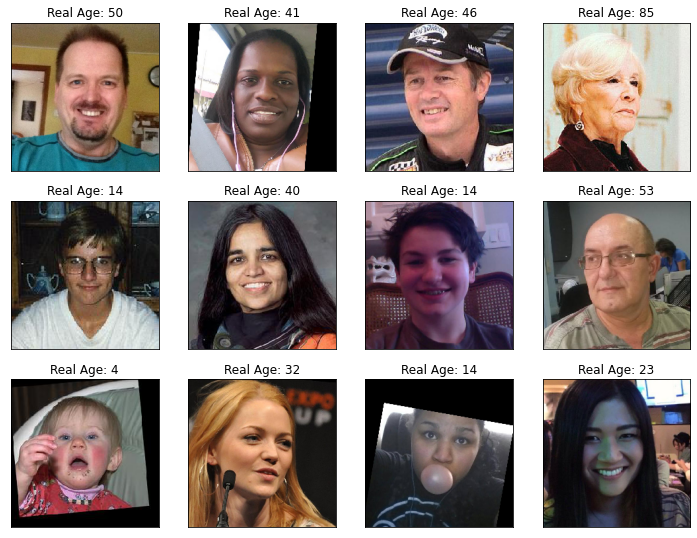

In [16]:
features, target = next(gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    
    # сохраняем в переменную age реальный возраст анкетированных людей
    age = int(target[i]) 
    
    # добавляем значение возраста в title
    plt.title(f'Real Age: {age}') 
    
    plt.tight_layout()

plt.show()

`Вывод`: выборка относительно немалая, более 7К значений, распределение Пуассона, приближеное к нормальному.

Фото, вполне чёткие, подходящие для обучения. Разброс значений возраста вполне репрезентативный.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [7]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    datagen_flow = datagen.flow_from_dataframe(
        labels,
        path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    datagen_flow = datagen.flow_from_dataframe(
        labels,
        path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
            steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
            validation_data=test_data,
            batch_size=batch_size, epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2, shuffle=True)

    return model

## Анализ обученной модели

`Общий вывод:` Перед нами была поставлена задача посторения модели определяющей возраст человека по фотографии с коэффецентом MAE не более 8-ми.

Перед тем, как преступить к обучению модели определяющей возраст, был проведён исследовательский анализ данных (ИАД).

В результате проведённого анализа был выявлен размер выборки равный 7591 записям, со средним возрастом анкетированных 31,2 года, медианным возрастом 29 лет, а также минимальным и максимальным возрастом: 1 и 100 лет сответственно.

Было выполнено построение графика с респределением возраста анкетированных. График показал близкое к Пуассоновскому распределение с локальным всплеском околонулевых значений (возраста).

Фото, вполне чёткие, подходящие для обучения. Разброс значений возраста вполне репрезентативный.

`Обучение модели:`

Для обучения была применена архитектура ResNet50 с механизмом активации 'relu' и оптимизацией 'adam'

После обучения модели, была достигнута метрика потерь MAE 7.7959 на тестовой выборке, что меньше порогового значения 8.

Это говорит нам о том, что модель успешно справляется с определением возраста по фото на незнакомой выборке с малым коэффицентом ошибок.

`Совет бизнесу:` для получения максимально точных предсказаний, данная модель рекомендуется для идентификации фото людей в возрастном диапазрне 18-41 лет. Тк эта категория наиболее точно прездсказана моделью из-за особенности обучающей выбоки, проедскавленной, в основном, людьми 18-41 лет.
